# Optimization (in particular, a focus on SGD) 

Optimization problems exist in many forms. We will make use of a popular technique, Gradient Descent, and a potentially useful extension, under a well-behaved framework of function spaces designed to motivate the use-cases for more complex (and potentially less behaved) function spaces. 


Well behaved: 
1. ($\mathbb{H}:=L_2(\mathbb{R}^n) | \forall f,g \in \mathbb{R}^n, <f,g>  = \int_{\mu}(\bar{f}\bullet g)d\mu$
2.  f,g are square integrable, i.e. $\int\limits_{-\infty}^{\infty} |f(x)|^2 dx <\infty$ ) 
3. f, g are convex, i.e.: $\forall x_1, x_2 \in X, \forall t \in [0, 1]:  f(tx_1+(1-t)x_2)\leq t f(x_1)+(1-t)f(x_2)$

(phew, glad that is over)

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

import math
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

np.random.seed(1)

%matplotlib inline
np.random.seed(1)

In [2]:
N = 50
x = np.random.rand(N,1)*5
# Let the following command be the true function
beta_0 = round(math.exp(1),3) #whats this number? :)
beta_1 = round(math.pi, 3) #whats this number? :)

y = beta_0 + beta_1*x**2
# Get some noisy observations
y_obs = y + 5*np.random.randn(N,1)

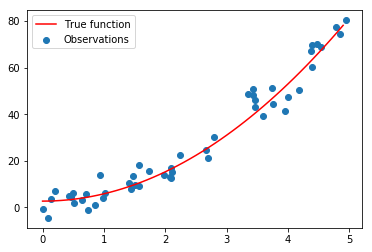

In [3]:
plt.scatter(x,y_obs,label='Observations')
#plt.plot(x,y,c='r',label='True function')
plt.plot(np.arange(0,5,step=0.1),beta_0 + beta_1*np.arange(0,5,step=0.1)**2,c='r',label='True function')
plt.legend()
plt.show()

So what do we do? We have to obtain some deravatives (because we want the gardient of the objective(loss) function). 

That is, we require: 

- $f$


- $S$, the objective or  loss function


- $\dfrac{dS}{d\beta_0}$


- $\dfrac{dS}{d\beta_1}$


- $\dfrac{df}{d\beta_0}$


- $\dfrac{df}{d\beta_1}$


In [4]:
def f(beta_0,beta_1):
    return beta_0 + beta_1*x**2

def loss_function(e):
    S = np.sum(np.square(e))/N
    return S

def dS_db_0(e,b_0,b_1):
    return -2*np.sum(e*df_db_0(b_0,b_1))/N

def dS_db_1(e,b_0,b_1):
    return -2*np.sum(e*df_db_1(b_0,b_1))/N

def df_db_0(b_0,b_1):
    return np.ones(x.shape)

def df_db_1(b_0,b_1):
    return x


In [5]:
# The Actual Gradient Descent (borrowed from https://github.com/sachinruk/deepschool.io, and modified for clarity)
def gradient_descent(iters=100,gamma=0.01):
    # get starting conditions
    b1 = .5
    b0 = .5
    params = []
    loss = np.zeros((iters,1))
    for i in range(iters):
        params.append([b0,b1])
        e = y_obs - f(b0,b1) # why are we using y_obs here? dont we know y??? do we know y, or more specifically, do we 'know' f()?
        loss[i] = loss_function(e)

        #update parameters
        b0_new = b0 - gamma * dS_db_0(e,b0,b1)
        b1_new = b1 - gamma * dS_db_1(e,b0,b1)
        
        b0 = b0_new
        b1 = b1_new 
        
        
    return params, loss
        
params, loss = gradient_descent()

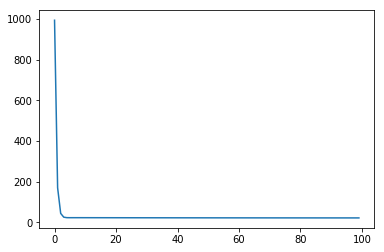

In [6]:
plt.plot(loss)

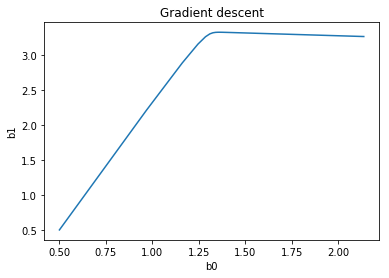

In [7]:
params = np.array(params)
plt.plot(params[:,0],params[:,1])
plt.title('Gradient descent')
plt.xlabel('b0')
plt.ylabel('b1')
plt.show()

In [8]:
params[-1]

array([ 2.13785523,  3.26078077])

Ok, that was kind of slow, what happens if we have a more general example? What about more data? Lets vectorize this. But first, lets discover some multivariate data!

In [9]:
N = 1000
D = 5
X = 5*np.random.randn(N,D)
betas = np.random.randn(D,1)
y = X.dot(betas)
y_obs = y + np.random.randn(N,1)

In [10]:
# Vectorized Helper Functions

#lets drop the intercept...because it really does not matter that much. 
def f_vec(betas):
    return X.dot(betas)

def loss_function(e):
    S = e.T.dot(e)/N
    return S

def dS_dbetas(e,betas):
    return -2*X.T.dot(e)/N

def vectorized_gradient_descent(iter=100,gamma=1e-3):
    # get starting conditions
    betas = np.random.randn(D,1) #this is the initialization
    params = []
    loss = np.zeros((iter,1))
    for i in range(iter):
        params.append(betas)
        e = y_obs - f_vec(betas) # Really important that you use y_obs and not y (you do not have access to true y)
        loss[i] = loss_function(e)

        #update parameters
        betas = betas - gamma*dS_dbetas(e,betas)
        
    return params, loss

In [11]:

        
params, loss = vectorized_gradient_descent()

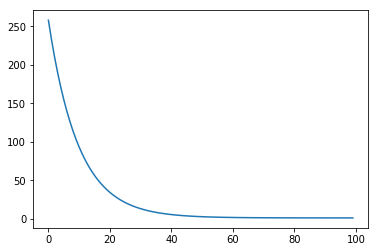

In [12]:
plt.plot(loss)

In [13]:
params[-1]

array([[-0.84394964],
       [-0.4814807 ],
       [-1.12598103],
       [ 0.07413685],
       [-1.21106272]])

In [14]:
model = LinearRegression(fit_intercept=False)
model.fit(X,y)
model.coef_.T

array([[-0.84914949],
       [-0.49471278],
       [-1.12743023],
       [ 0.09131194],
       [-1.22154224]])

So, we have confirmed to ourselves, that in some reasonable sense, this does work. How do we speed it up even more? Lets look at Stochastic Gradient Descent. 

In [19]:
N = 1000
D = 3
X = 5*np.random.randn(N,D)
betas = np.array([[math.pi],[math.exp(1)],[30]])
y = X.dot(betas)
y_obs = y + np.random.randn(N,1)

In [23]:
def dS_dbetas(X,e,betas):
    return -2*X.T.dot(e)/len(X)

def stochastic_gradient_descent(gamma=1e-2, n_epochs=100, batch_size=20, decay=0.9):
    epoch_run = int(len(X)/batch_size)
    
    # get starting conditions
    betas = np.random.randn(D,1)
    params = []
    loss = np.zeros((n_epochs,1))
    for i in range(n_epochs):
        params.append(betas)
        
        for j in range(epoch_run):
            idx = np.random.choice(len(X),batch_size,replace=False)
            e = y_obs[idx] - X[idx].dot(betas) # Really important that you use y_obs and not y (you do not have access to true y)
            #update parameters
            betas = betas - gamma*dS_dbetas(X[idx],e,betas)
        loss[i] = e.T.dot(e)/len(e)    
        gamma = gamma*decay #decay the learning parameter
        
    return params, loss
        
params, loss = stochastic_gradient_descent()

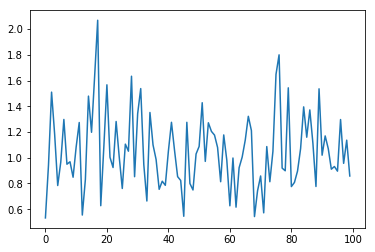

In [24]:
plt.plot(loss)

In [26]:
params[-1]

array([[  3.14531212],
       [  2.71317329],
       [ 29.99795333]])